In [1]:
import numpy as np

In [17]:
sport = np.random.multivariate_normal([1, 4], np.diag([0.5, 2]), size=100)
miam = np.random.multivariate_normal([2, 2], np.diag([1, 1.5]), size=100)
dodo = np.random.multivariate_normal([3, 4], np.diag([1, 1]), size=100)

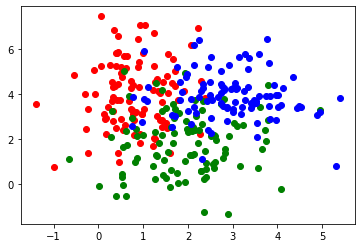

In [18]:
import matplotlib.pyplot as plt

plt.scatter(sport[:, 0], sport[:, 1], c='r')
plt.scatter(miam[:, 0], miam[:, 1], c='g')
plt.scatter(dodo[:, 0], dodo[:, 1], c='b')

In [34]:
from enum import Enum

class State(Enum):
    DODO = 0
    MIAM = 1
    RUN = 2

states = [State.DODO, State.MIAM, State.RUN]

In [31]:
transition = np.zeros((3, 3))
transition[State.DODO.value, State.DODO.value] = 9/10
transition[State.DODO.value, State.MIAM.value] = 1/10 / 2
transition[State.DODO.value, State.RUN.value] = 1/10 / 2
transition[State.MIAM.value, State.RUN.value] = 3/10
transition[State.MIAM.value, State.DODO.value] = 7/10
transition[State.RUN.value, State.DODO.value] = 8/10
transition[State.RUN.value, State.RUN.value] = 2/10
transition

array([[0.9 , 0.05, 0.05],
       [0.7 , 0.  , 0.3 ],
       [0.8 , 0.  , 0.2 ]])

In [33]:
transition @ transition

array([[0.885, 0.045, 0.07 ],
       [0.87 , 0.035, 0.095],
       [0.88 , 0.04 , 0.08 ]])

In [38]:
def random_step(z):
    return np.random.choice(states, p=transition[z.value])

In [41]:
def random_walk(n_steps=10):
    walk = [State.DODO]
    for _ in range(n_steps):
        walk.append(random_step(walk[-1]))
    return walk

In [43]:
random_walk(25)

[<State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.MIAM: 1>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.MIAM: 1>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.MIAM: 1>,
 <State.RUN: 2>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>]